In [48]:
%load_ext autoreload
%autoreload 2
import numpy as np

from scipy.optimize import curve_fit

from qs_mps.mps_class import MPS
from qs_mps.utils import tensor_shapes, von_neumann_entropy, load_list_of_lists, get_precision

import matplotlib.pyplot as plt
import matplotlib as mpl


# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

model = "Z2_dual"
path = "mac"

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    cx = None
    cy = None
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    parent_path = f"G:/My Drive/projects/{model_path}"
    path_tensor = f"D:/code/projects/{model_path}"
    path_rdms = "C:/Users/HP/Desktop/fidelity-phase-tran"
elif path == "mac":
    parent_path = f"/Users/fradm98/Google Drive/My Drive/projects/{model_path}"
    path_tensor = f"/Users/fradm98/Desktop/projects/{model_path}"
    path_rdms = "/Users/fradm98/Desktop/fidelity-phase-tran"
elif path == "marcos":
    parent_path = f"/Users/fradm/Google Drive/My Drive/projects/{model_path}"
    path_tensor = f"/Users/fradm/Desktop/projects/{model_path}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Check Schmidt Values

We check the trend of the schmidt values for different lattice sizes of the $\mathbb{Z}_2$ model changing the Hamiltonian parameter $g$.

$$ H = -g\sum_{i}\sigma_i^x -\frac{1}{g} \sum_{i}\square_i^{Plaquette} $$

## Retrieving Schmidt Values from MPS sites

In [4]:
# let us retrieve the schmidt values from the tensors
lattice = MPS(L=7, d=64, chi=256, h=3.06, model="Z2_dual")
lattice.load_sites(path="/Users/fradm/Desktop/projects/1_Z2", precision=2)
lattice.L = lattice.L - 1
tensor_shapes(lattice.sites)
lattice.check_canonical(site=0)

(1, 64, 64)
(64, 64, 256)
(256, 64, 256)
(256, 64, 256)
(256, 64, 64)
(64, 64, 1)
the tensor at site 6 is in the correct RFC
the tensor at site 5 is in the correct RFC
the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct RFC
the tensor at site 2 is in the correct RFC


In [5]:
lattice.canonical_form(svd_direction="right")
lattice.bonds[lattice.L // 2]

array([9.90912743e-01, 8.73556071e-02, 6.35354214e-02, 4.87155080e-02,
       3.99065065e-02, 3.42242968e-02, 3.33518815e-02, 7.12913212e-03,
       5.34182615e-03, 4.24056239e-03, 3.61954095e-03, 3.56394077e-03,
       3.43052704e-03, 2.97169732e-03, 2.54002328e-03, 2.46797922e-03,
       2.16043437e-03, 1.86960523e-03, 1.81665328e-03, 1.46374649e-03,
       1.42099410e-03, 1.16648279e-03, 6.79332416e-04, 4.71372972e-04,
       3.63160430e-04, 3.07207020e-04, 3.07189549e-04, 2.84981293e-04,
       2.64280204e-04, 2.22701343e-04, 2.12236869e-04, 1.86282797e-04,
       1.70626291e-04, 1.64687370e-04, 1.58978374e-04, 1.55273413e-04,
       1.51808914e-04, 1.33571979e-04, 1.24601398e-04, 1.19528584e-04,
       9.91714176e-05, 9.43743080e-05, 8.88857374e-05, 8.55423262e-05,
       7.17796156e-05, 7.13162100e-05, 6.53756136e-05, 6.19599228e-05,
       5.43115928e-05, 5.37830515e-05, 4.26352962e-05, 3.55514918e-05,
       3.07374869e-05, 2.81128997e-05, 2.75974581e-05, 2.57009649e-05,
      

### Now we compare them with the ones obtained during the dmrg algorithm

In [28]:
out_vals = np.array([9.93929111e-01, 7.34952094e-02, 5.28744017e-02, 4.07422683e-02,
       3.36582755e-02, 3.21475833e-02, 5.16470314e-03, 3.89784880e-03,
       3.12915114e-03, 2.95743910e-03, 2.53641519e-03, 2.10594326e-03,
       2.00834282e-03, 1.51805982e-03, 1.44529170e-03, 1.11770101e-03,
       3.48809141e-04, 2.91587248e-04, 2.33010629e-04, 2.12161204e-04,
       1.64967300e-04, 1.59449677e-04, 1.54517205e-04, 1.18115150e-04,
       1.11919495e-04, 1.04435801e-04, 8.42850176e-05, 8.28083599e-05,
       5.68035185e-05, 5.36603695e-05, 4.82666319e-05, 3.30993049e-05,
       2.46699125e-05, 1.98004982e-05, 1.54215874e-05, 1.50221703e-05,
       1.38848166e-05, 1.38621399e-05, 1.22847764e-05, 1.16220979e-05,
       9.65779024e-06, 9.55866192e-06, 7.01352014e-06, 6.86536032e-06,
       6.74635346e-06, 6.54514226e-06, 5.47386922e-06, 5.41445566e-06,
       4.74541327e-06, 4.74102691e-06, 4.13916490e-06, 3.74749494e-06,
       3.50450070e-06, 3.18486410e-06, 3.15892518e-06, 2.75885130e-06,
       2.53412850e-06, 2.38589731e-06, 2.33508667e-06, 2.23597795e-06,
       1.82648162e-06, 1.80990163e-06, 1.67029700e-06, 1.47096288e-06,
       1.43347192e-06, 1.42921337e-06, 1.13868899e-06, 1.12762200e-06,
       9.91021315e-07, 9.00999836e-07, 8.63270191e-07, 8.51366046e-07,
       6.65939313e-07, 6.56371801e-07, 6.16878749e-07, 6.09913423e-07,
       5.89048685e-07, 5.25698712e-07, 4.98873669e-07, 4.82780164e-07,
       4.19546988e-07, 4.10371513e-07, 4.00094610e-07, 3.78629203e-07,
       3.65914202e-07, 3.59477445e-07, 3.20106836e-07, 2.88275127e-07,
       2.76533134e-07, 2.55410377e-07, 2.52153797e-07, 2.38390053e-07,
       2.35500543e-07, 2.23963589e-07, 2.08467203e-07, 2.05664333e-07,
       2.01187470e-07, 1.95607045e-07, 1.81971057e-07, 1.79045056e-07,
       1.71294166e-07, 1.70070350e-07, 1.55306606e-07, 1.45613984e-07,
       1.38145938e-07, 1.29408589e-07, 1.25963710e-07, 1.25256152e-07,
       1.13187648e-07, 9.87313489e-08, 9.31058496e-08, 9.13666521e-08,
       8.56291067e-08, 7.84980539e-08, 7.48771950e-08, 7.38627282e-08,
       6.16095347e-08, 5.75512421e-08, 5.62427455e-08, 4.94123769e-08,
       4.28056863e-08, 3.76087933e-08, 3.24351254e-08, 3.06814162e-08,
       3.04202716e-08, 2.67351532e-08, 2.13443098e-08, 1.88046100e-08])

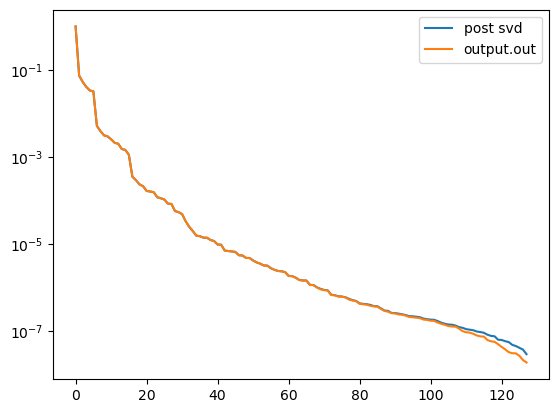

In [40]:
plt.plot(lattice.bonds[lattice.L // 2], label="post svd")
plt.plot(out_vals, label="output.out")
plt.yscale('log')
plt.legend()
plt.show()

## Schmidt values with different bond dimensions $\chi$

### Last schmidt value for all points

In [49]:
L = 6
l = 5
npoints = 50
chis = [32, 128, 256]
hx_i = 1.0
hx_f = -3.0
lin, log, retrieve = False, True, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)

In [13]:
schmidt_vals_chi = []
entropy_chi = []
bond_dim_chi = []

threshold = 1e-15
params = [[h,chi] for chi in chis for h in interval]
params_extent = np.concatenate([np.min(params, axis=0), np.max(params, axis=0)])
params_extent = tuple(params_extent[[0, 2, 1, 3]])
prob = []
for chi in chis:
    schmidt_vals_h = []
    bond_dim_h = []
    entropy_h = []
    if retrieve:
        for h in interval:
            lattice = MPS(L=L, d=2**l, chi=chi, h=h, model="Z2_dual")
            lattice.load_sites(path="/Users/fradm98/Desktop/projects/1_Z2", precision=precision)
            lattice.L = lattice.L - 1
            lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
            sm = lattice.bonds[lattice.L // 2].copy()
            prob = np.sum(sm**2)
            print("pre", len(sm), sm[-1], prob)
            sm = sm[sm > threshold]
            prob = np.sum(sm**2)
            print("post", len(sm), sm[-1], prob)
            entr = von_neumann_entropy(sm)
            entropy_h.append(entr)
            schmidt_vals_h.append(sm[-1])
            bond_dim_h.append(len(sm))
    else:
        sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        bond_dim_h = [len(sm[sm>threshold]) for sm in sm_h]
        schmidt_vals_h = sm_h[:,-1]
        entropy_h = [von_neumann_entropy(sm) for sm in sm_h]


    schmidt_vals_chi.append(schmidt_vals_h)
    bond_dim_chi.append(bond_dim_h)
    entropy_chi.append(entropy_h)

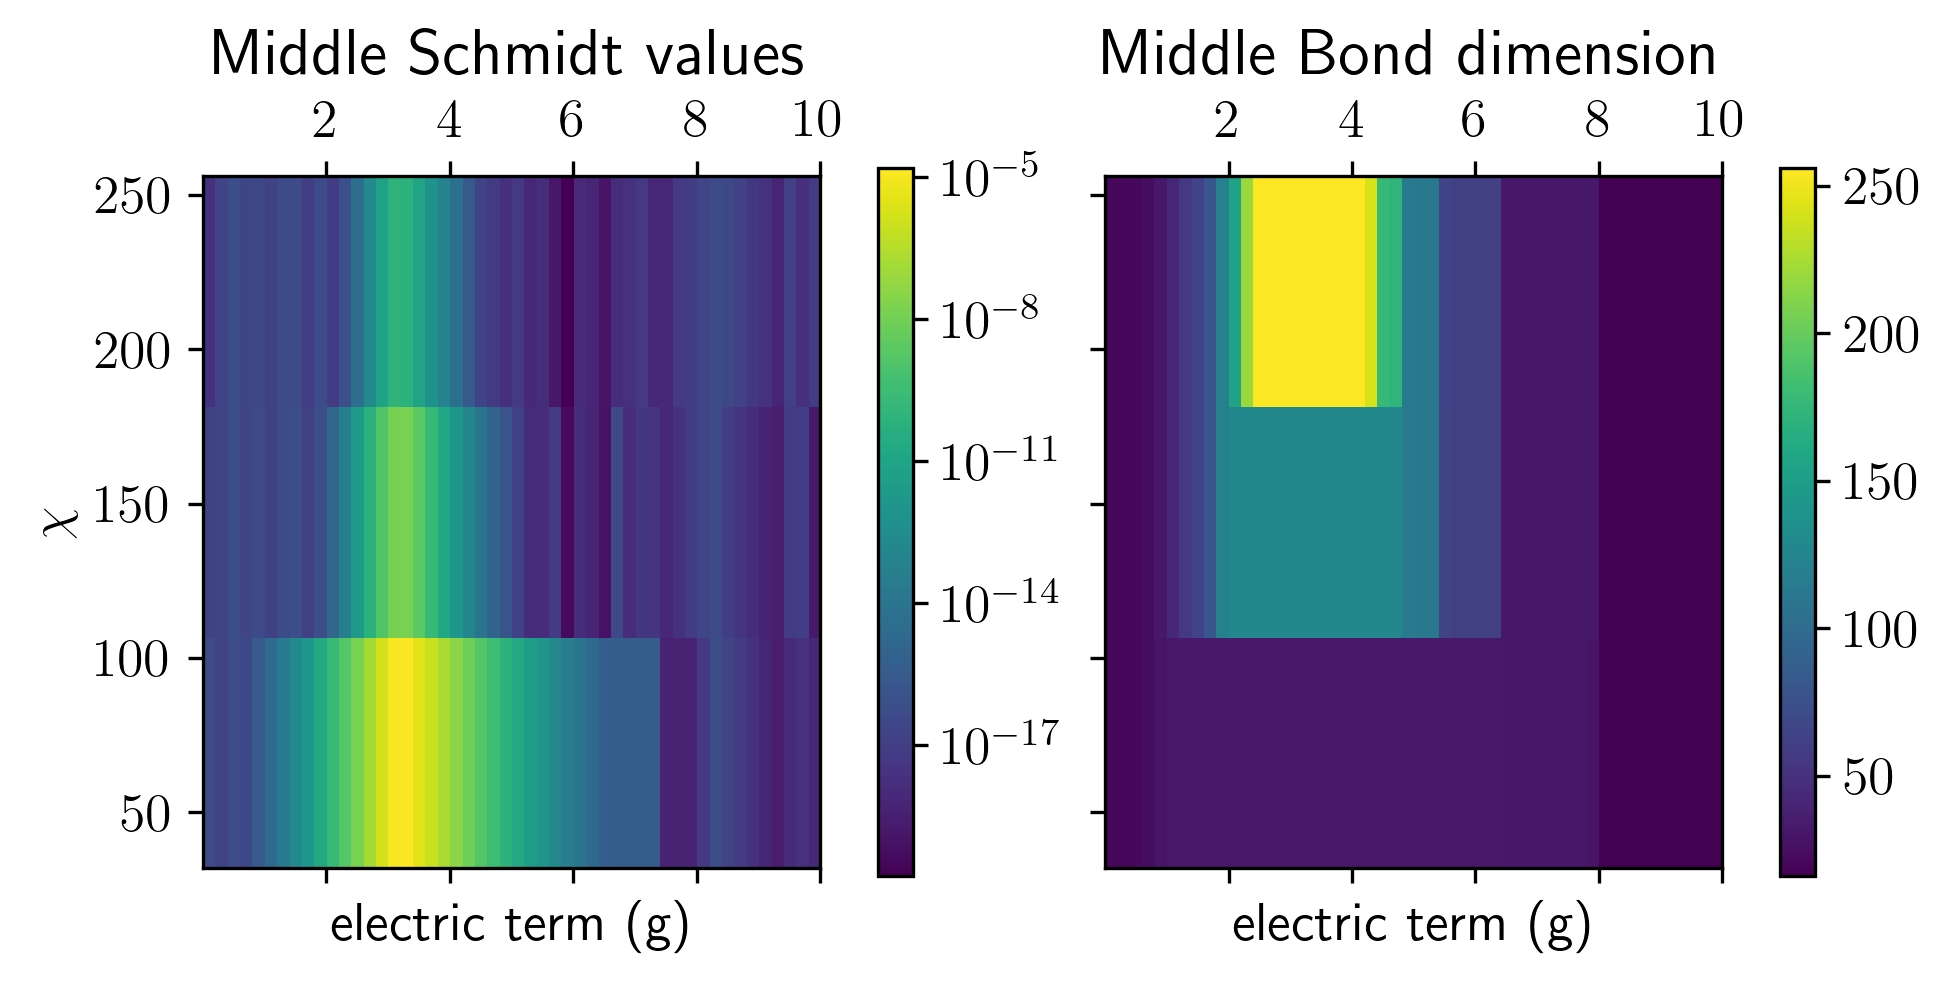

In [12]:
from matplotlib import colors
fig, axs = plt.subplots(1,2, sharey=True)
matshow0 = axs[0].matshow(schmidt_vals_chi, origin='lower', extent=params_extent, aspect=0.05, norm=colors.LogNorm(vmin=np.min(schmidt_vals_chi), vmax=np.max(schmidt_vals_chi)))
axs[0].set_title("Middle Schmidt values")
axs[0].set_ylabel("$\chi$")
axs[0].set_xlabel("electric term (g)")
matshow1 = axs[1].matshow(bond_dim_chi, origin='lower', extent=params_extent, aspect=0.05)
axs[1].set_title("Middle Bond dimension")
axs[1].set_xlabel("electric term (g)")
fig.colorbar(matshow0, ax=axs[0], shrink=0.5)
fig.colorbar(matshow1, ax=axs[1], shrink=0.5)

## Entropy

### Entropy with different bond dimensions $\chi$

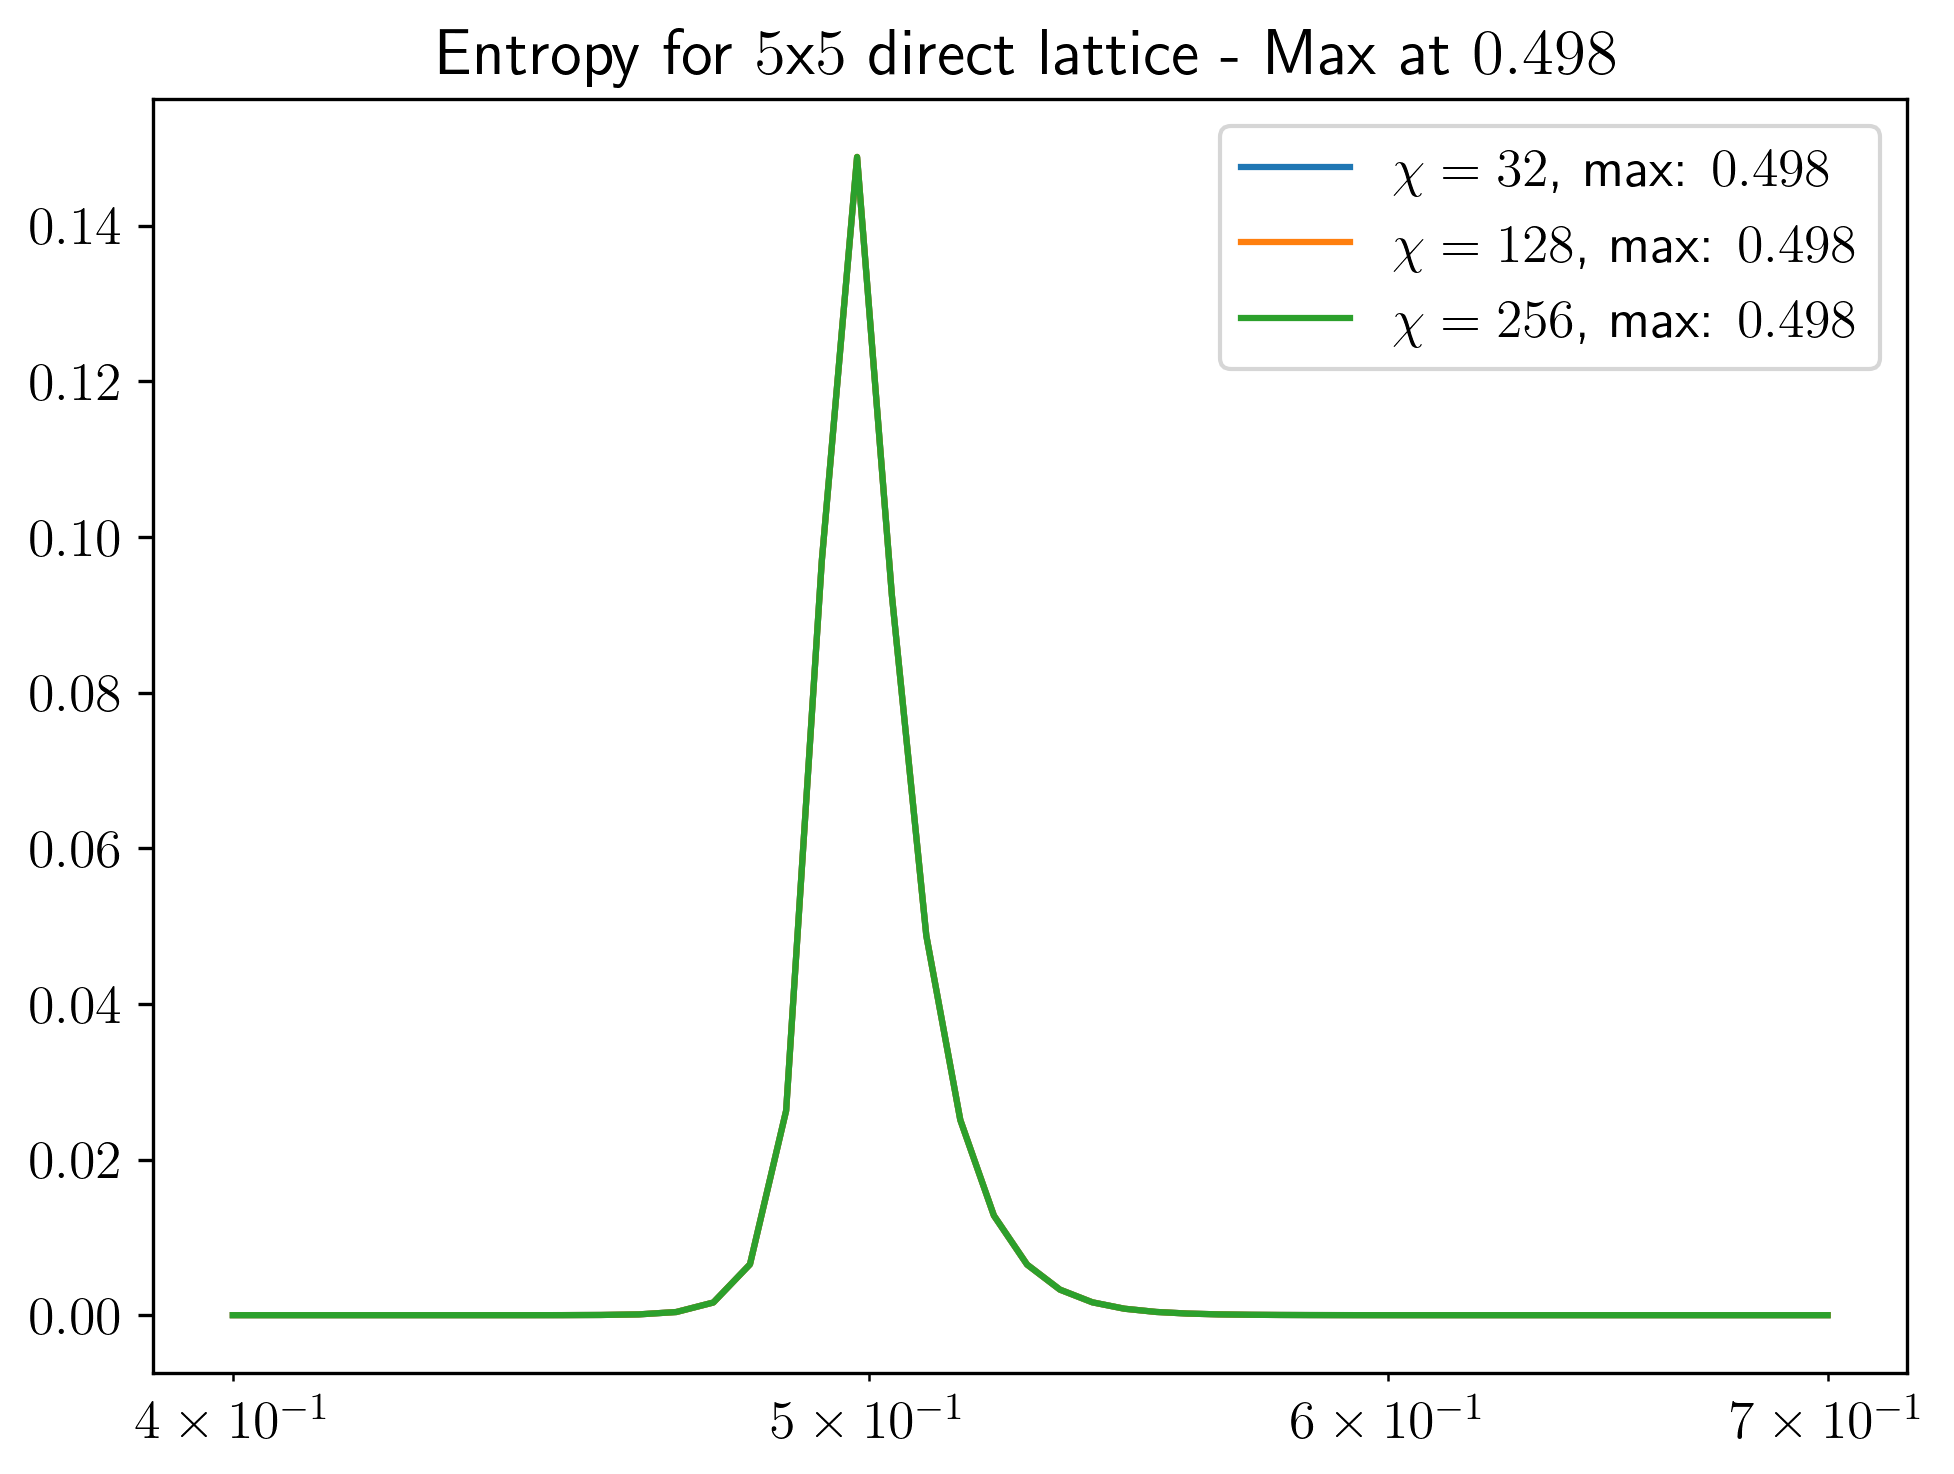

In [31]:
entr_tot = []
if retrieve:
    for chi, entropy in zip(chis, entropy_chi):
        entr_h = entropy
        idx_max = np.argmax(entr_h)
        g_max = round(interval[np.argmax(entr_h)],4)
        plt.plot(interval, entr_h, label=f"$\chi={chi}$, max: ${g_max}$")
        entr_tot.append(entr_h)
        
else:
    for chi in chis:
        sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        entr_h = [von_neumann_entropy(sm) for sm in sm_h]
        idx_max = np.argmax(entr_h)
        g_max = round(interval[np.argmax(entr_h)],4)
        plt.plot(interval, entr_h, label=f"$\chi={chi}$, max: ${g_max}$")
        entr_tot.append(entr_h)

if log:
    plt.xscale('log')
# plt.yscale('log')
plt.title(f"Entropy for ${l}$x${L-1}$ direct lattice - Max at ${g_max}$");
plt.legend()
plt.savefig(f"{parent_path}/figures/entropy/{L//2}_bond_entropy_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.png");

### Entropy difference

(3, 50)


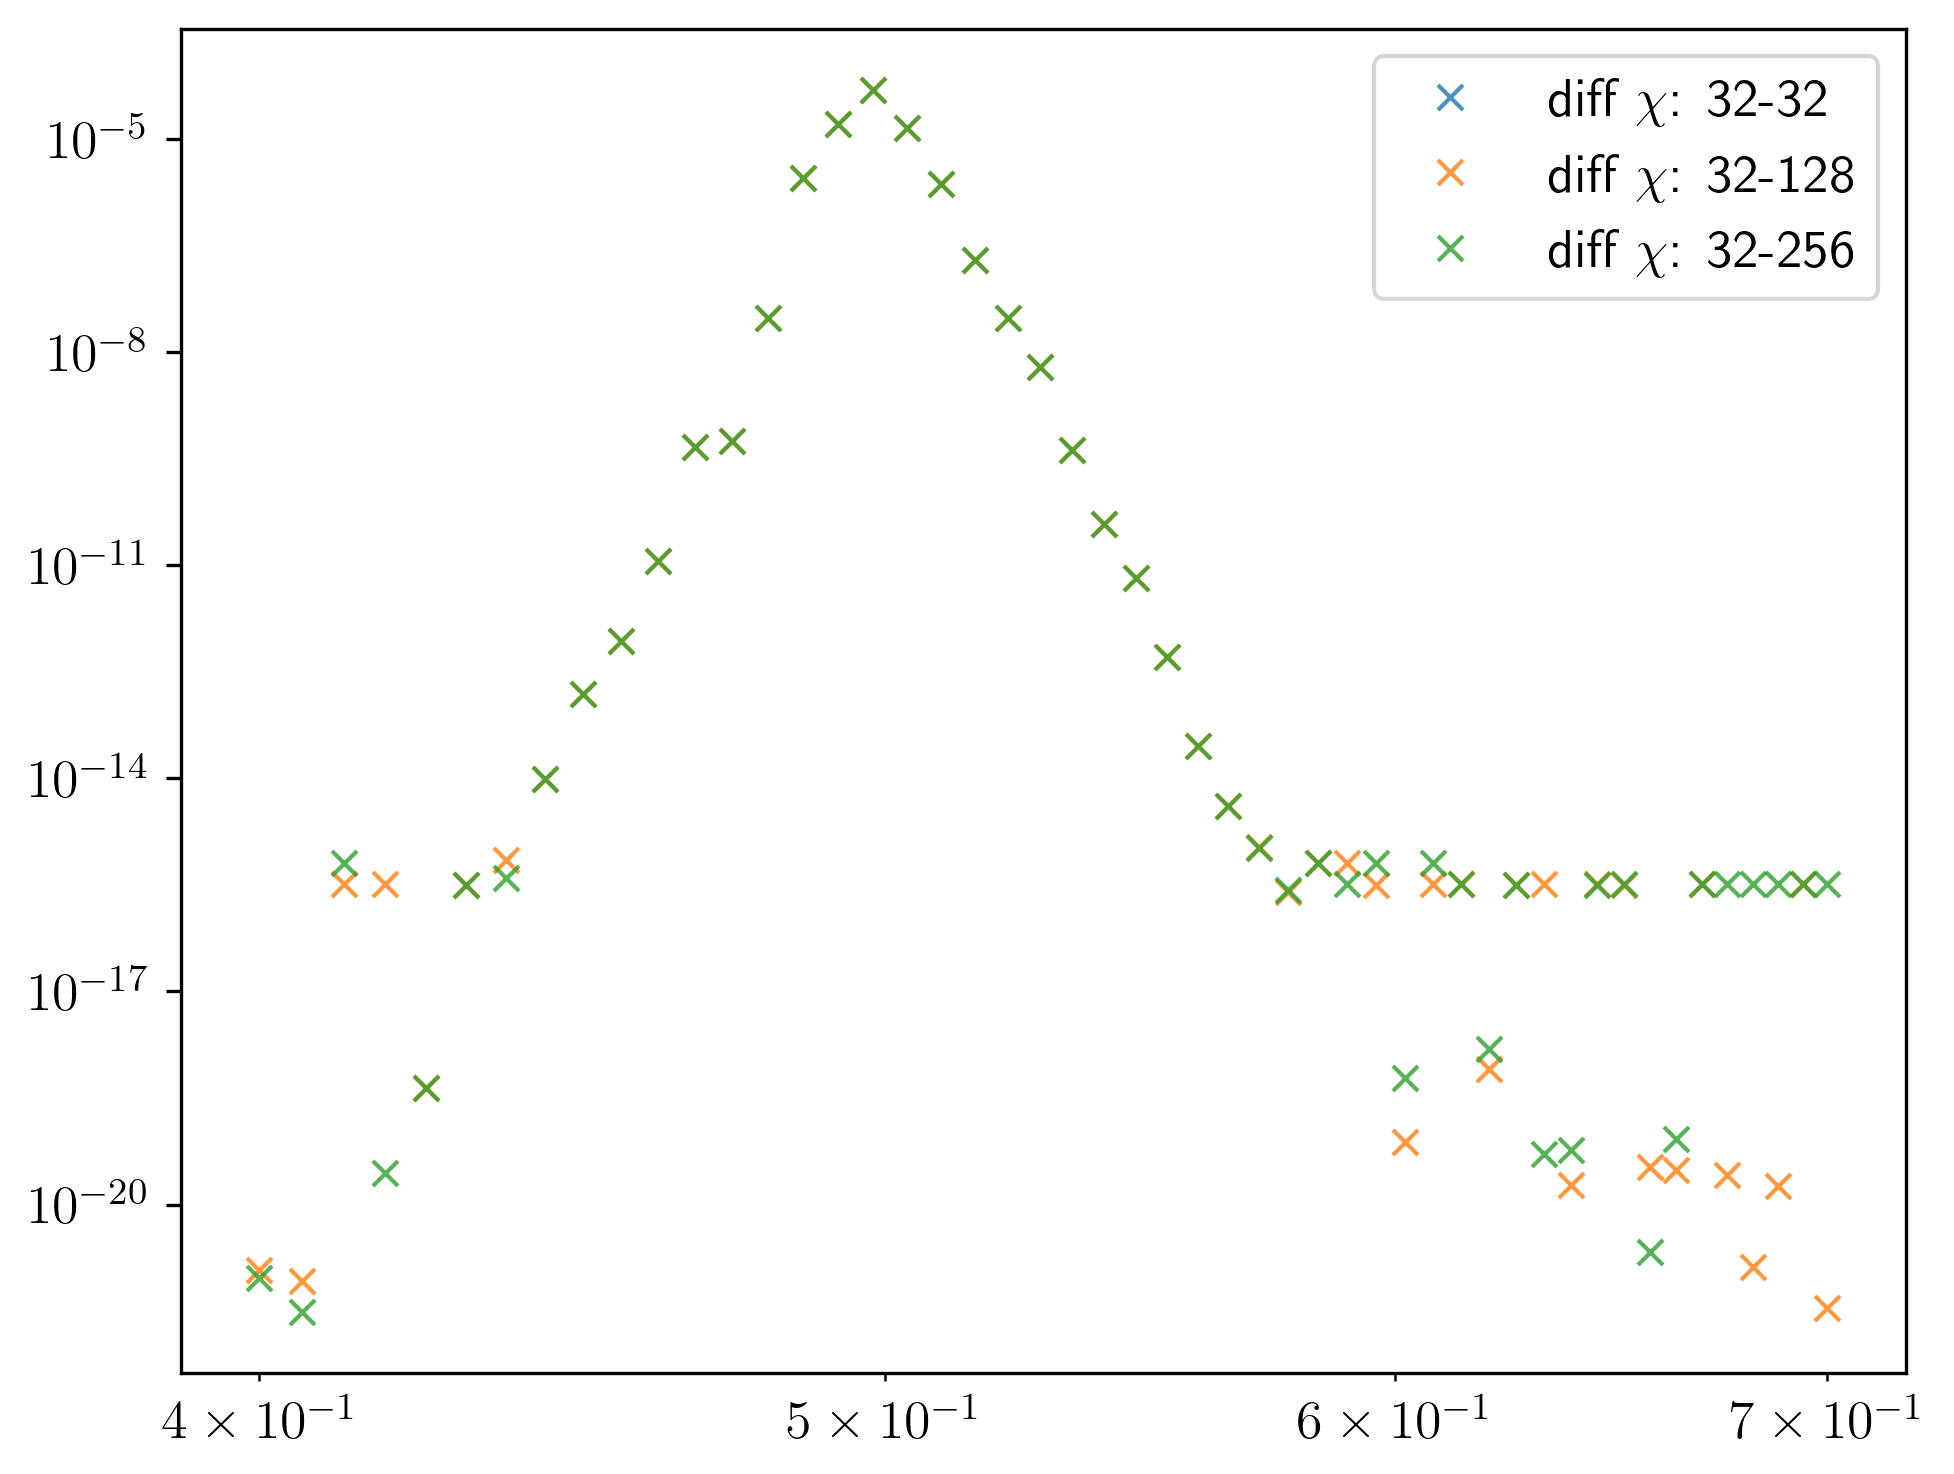

In [28]:
i = 0
entr_tot = np.asarray(entr_tot)
print(entr_tot.shape)
for chi, entr in zip(chis, entr_tot):
    entr_diff = np.abs(entr_tot[0]-entr_tot[i])
    plt.plot(interval, entr_diff, 'x', alpha=0.8, label=f"diff $\chi$: {chis[0]}-{chis[i]}")
    i += 1
plt.legend()
if log:
    plt.xscale("log")
plt.yscale("log")
plt.show()

### Schmidt Values decay in the point fo maximum entropy

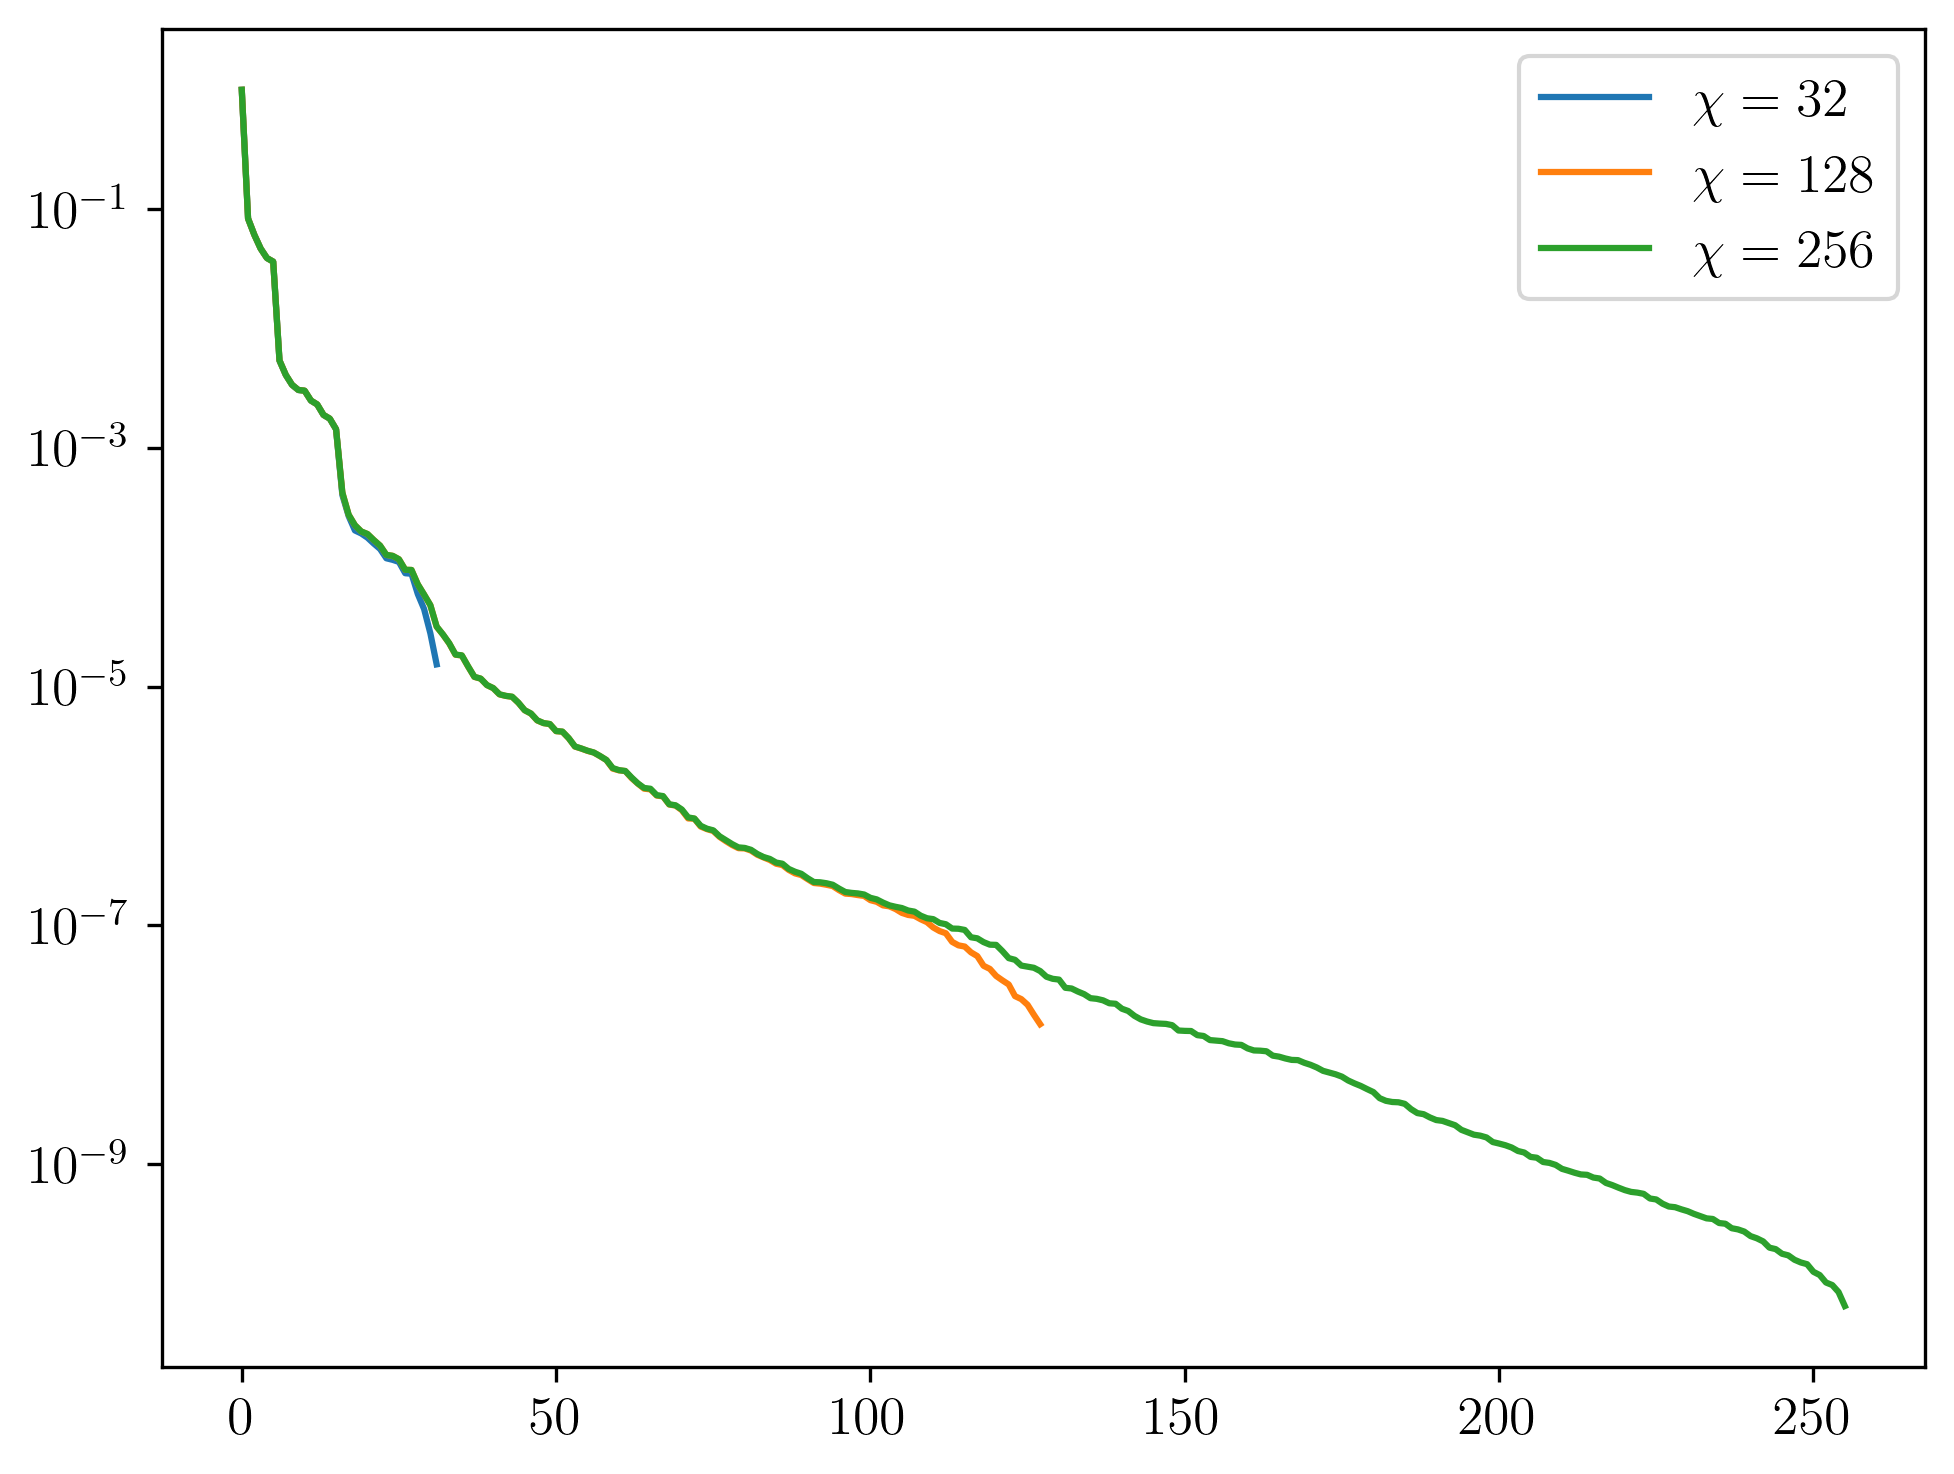

In [42]:
schmidt_vals_chi = []
for chi in chis:
    if retrieve:
        lattice = MPS(L=L, d=2**l, chi=chi, h=interval[idx_max], model="Z2_dual")
        lattice.load_sites(path="/Users/fradm98/Desktop/projects/1_Z2", precision=precision)
        lattice.L = lattice.L - 1
        lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
        sm_h = lattice.bonds[lattice.L // 2].copy()
        schmidt_vals_chi.append(sm_h)
    else:
        sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        sm_h = sm_h[idx_max,:]
        schmidt_vals_chi.append(sm_h)
    plt.plot(sm_h, label=f"$\chi={chi}$")
plt.legend()
plt.yscale('log')
plt.show()

### Schmidt values decay for all points, $\chi_{max}$

Text(0.5, 1.0, 'Schmidt values decay for $5$x$5$ direct lattice - $\\chi=256$')

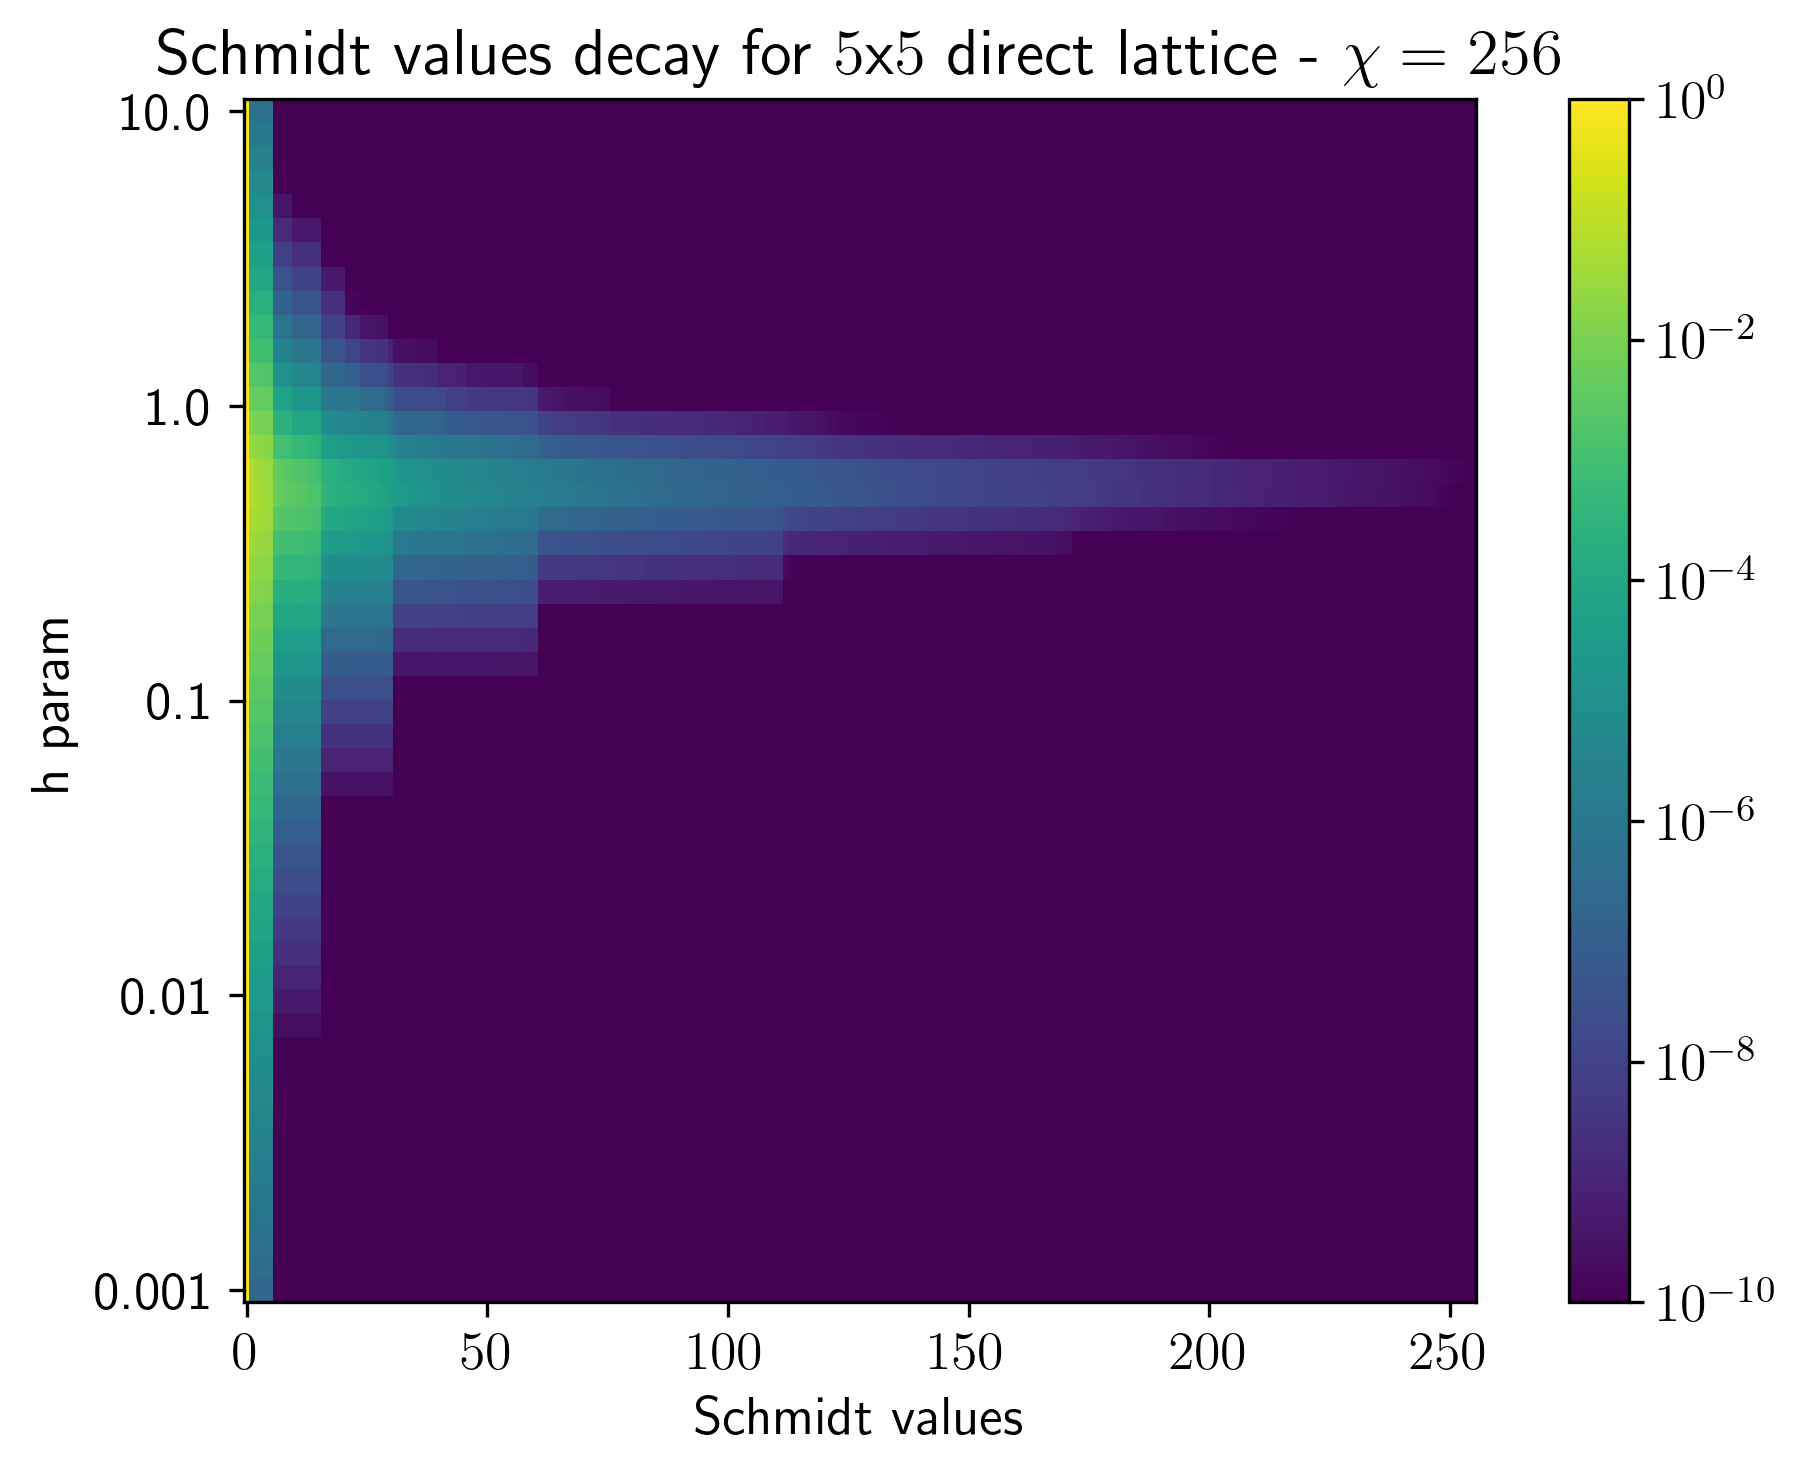

In [47]:
chi = chis[-1]
schmidt_vals_h
for h in interval:
    if retrieve:
        lattice = MPS(L=L, d=2**l, chi=chi, h=interval[idx_max], model="Z2_dual")
        lattice.load_sites(path=path_tensor, precision=precision)
        lattice.L = lattice.L - 1
        lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
        sm_h = lattice.bonds[lattice.L // 2].copy()
        schmidt_vals_h.append(sm_h)
    else:
        sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        schmidt_vals_h = sm_h

plt.imshow(schmidt_vals_h, cmap="viridis", norm=mpl.colors.LogNorm(vmin=1e-10, vmax=1), aspect=5)
plt.colorbar(shrink=1)
hs_y = np.logspace(1,-3,5)
y = np.linspace(0,49,5)
plt.yticks(y, hs_y)
plt.ylabel("h param")
plt.xlabel("Schmidt values")
plt.title("Schmidt values decay for $5$x$5$ direct lattice - $\chi=256$")

## Observing different lattices

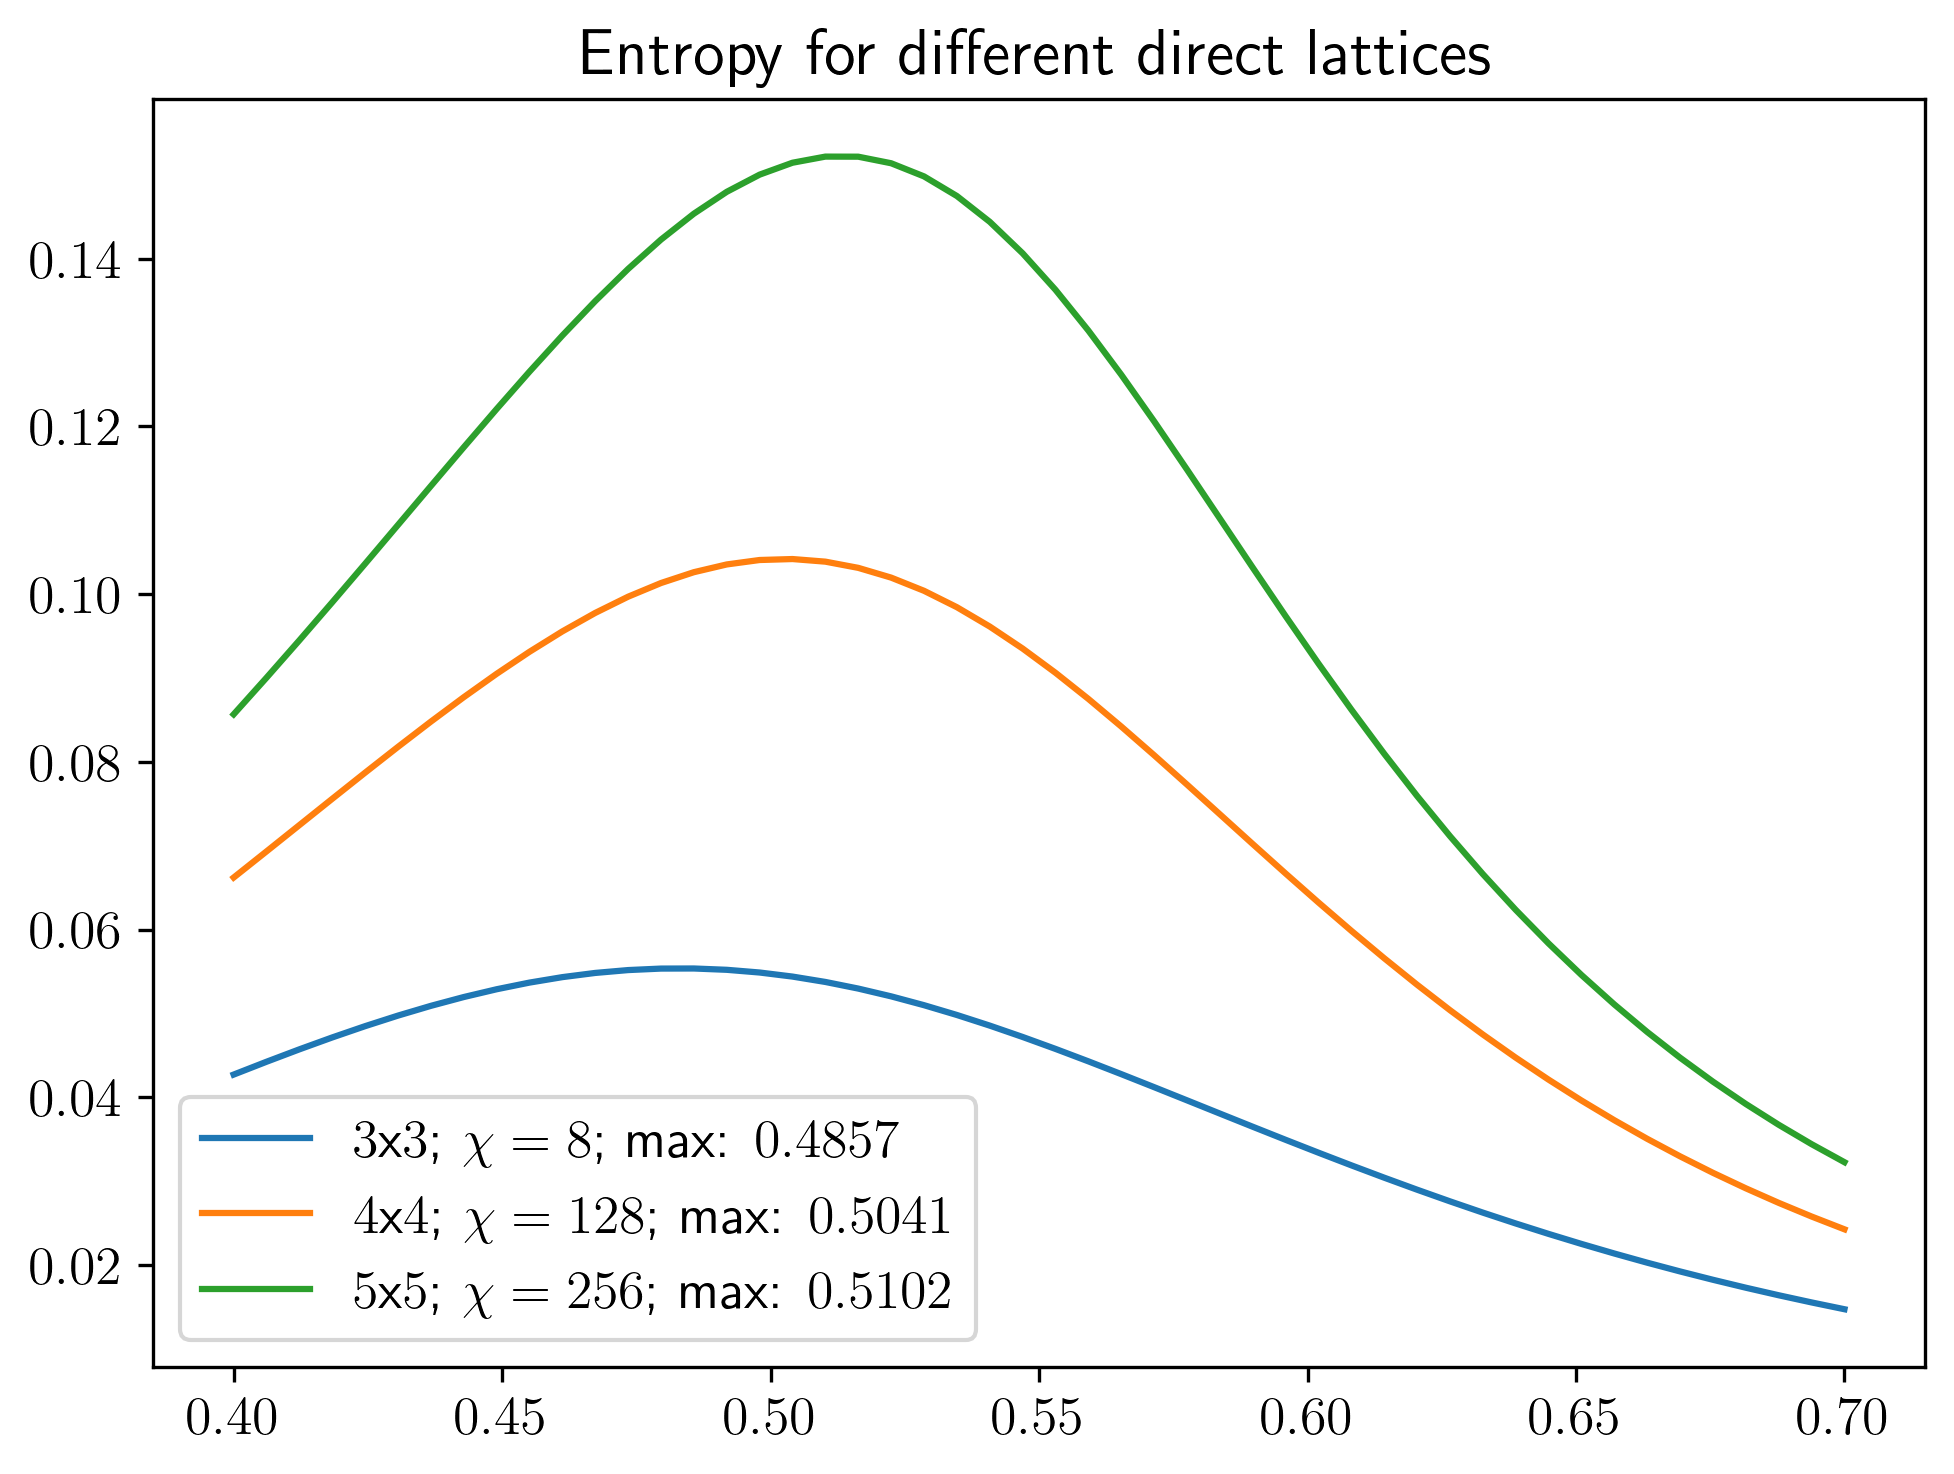

In [50]:
Ls = [4,5,6]
chis = [32, 128, 256]
hx_i = 0.4
hx_f = 0.7
npoints = 50
lin, log, retrieve = True, False, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)
chis = [8,128,256]
threshold = 1e-15
entr_tot = []
for chi, L in zip(chis, Ls):
    sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{L-1}x{L-1}_{sector}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy", allow_pickle=True)
    sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
    entr_h = [von_neumann_entropy(sm) for sm in sm_h]
    g_max = round(interval[np.argmax(entr_h)], 4)

    plt.plot(interval, entr_h, label=f"${L-1}$x${L-1}$; $\chi={chi}$; max: ${g_max}$")
    entr_tot.append(entr_h)

plt.legend()
plt.title(f"Entropy for different direct lattices")
if log:
    plt.xscale('log')
# plt.yscale('log')
plt.savefig(f"{parent_path}/figures/entropy/{L//2}_bond_entropy_Z2_dual_direct_lattice_L_{Ls}_{sector}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chis}.png")
plt.show()

### Thermodynamic extrapolation

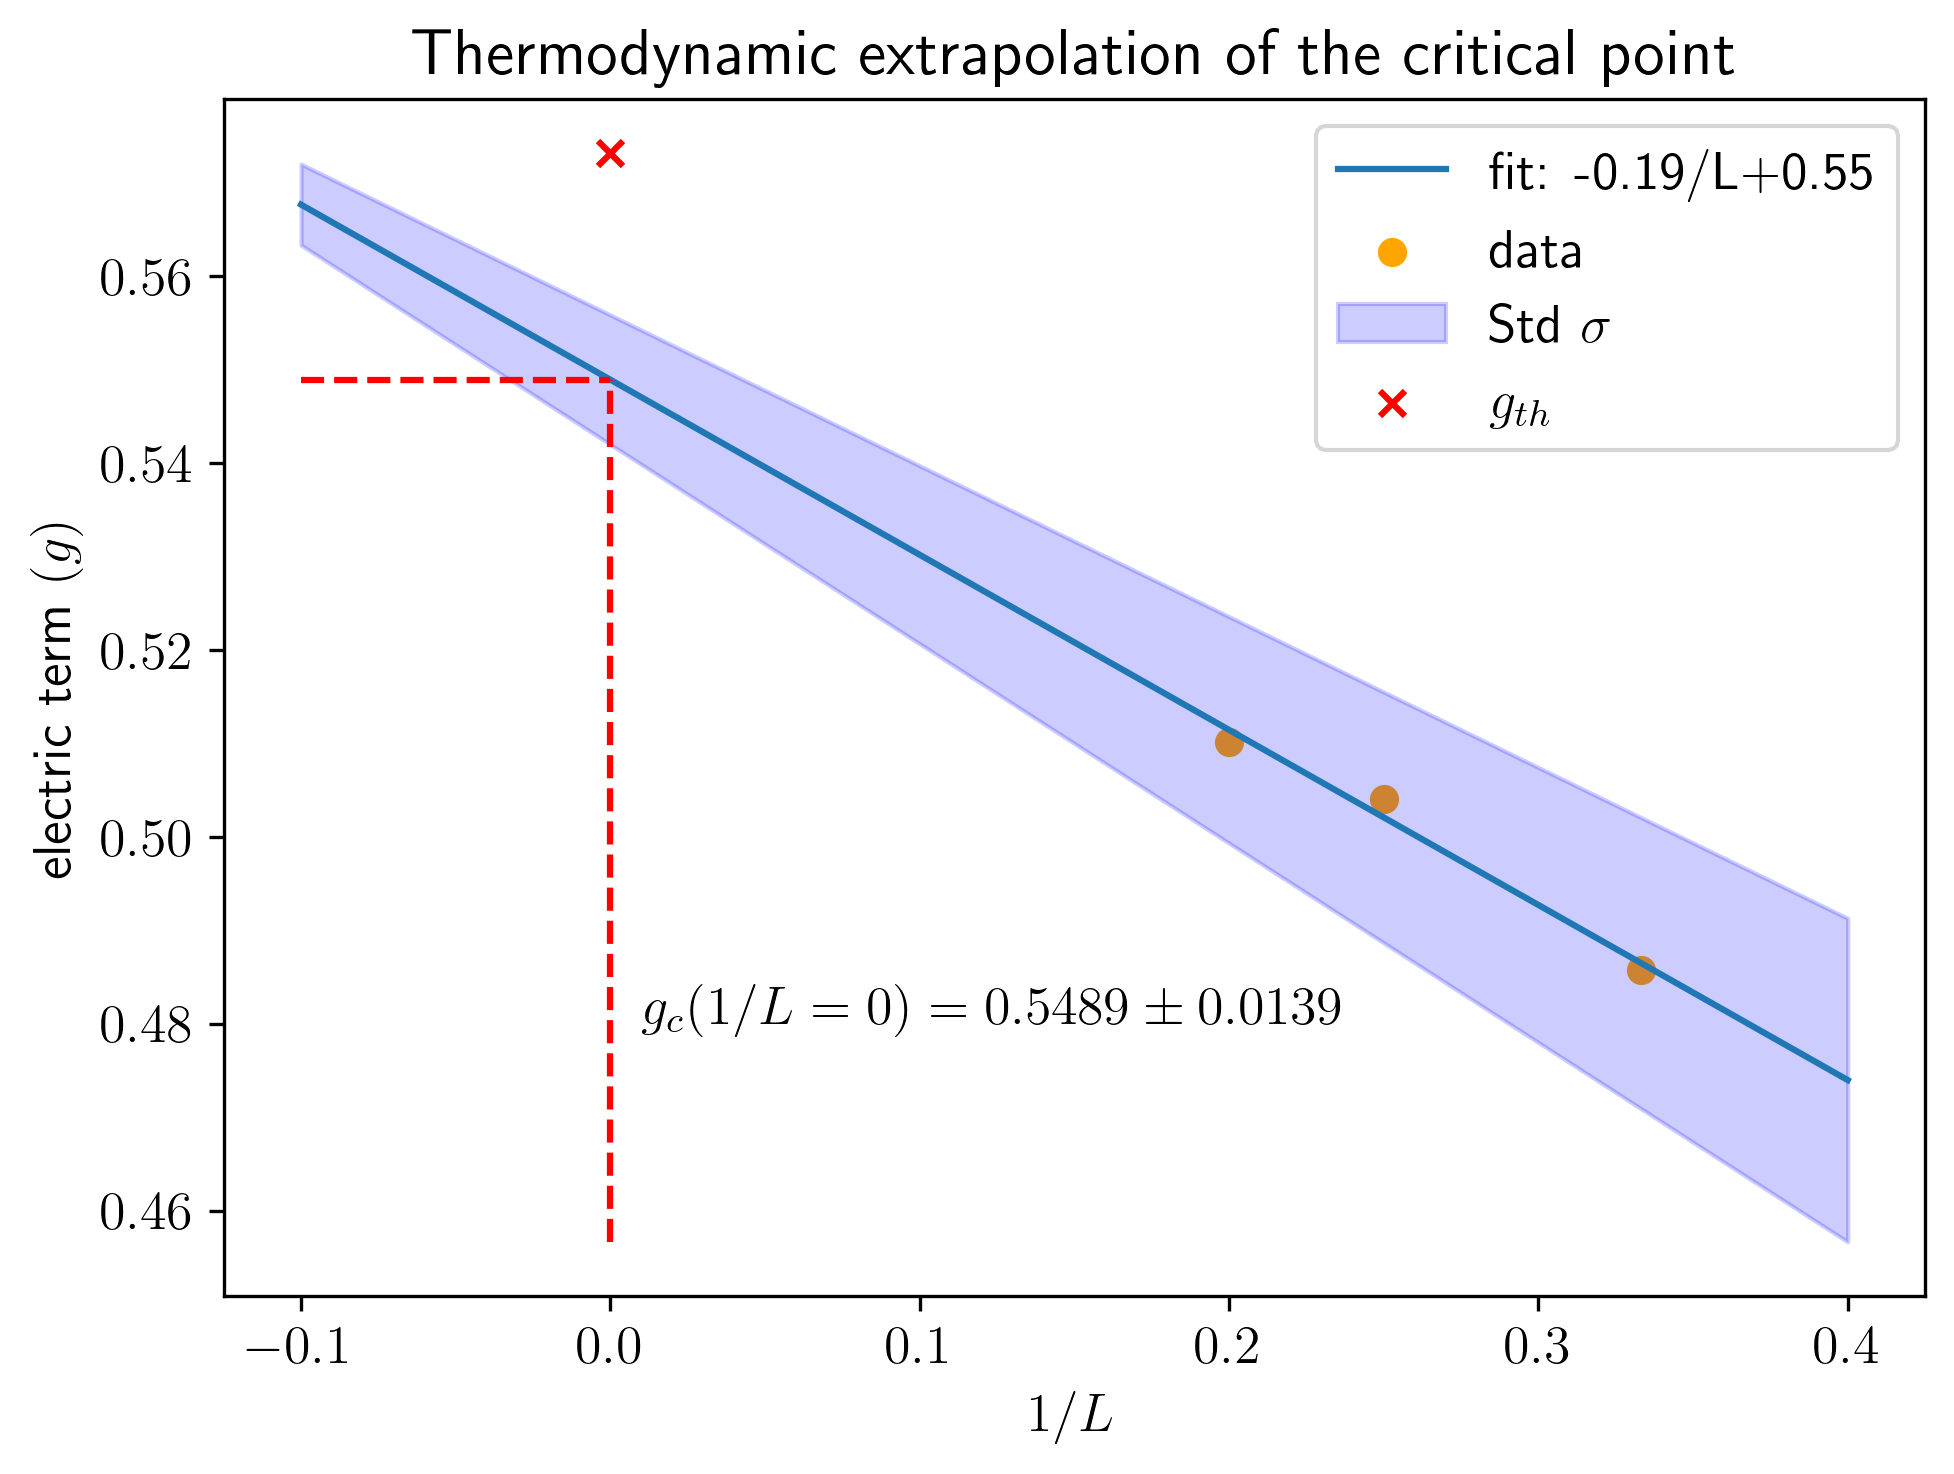

In [51]:
entr_max = []
idx_max = []
Ls_inv = [1/3,1/4,1/5]
for entr, L in zip(entr_tot, Ls):
    entr_max.append(np.max(entr))
    idx_max.append(np.argmax(entr))

# linear fit
def lin(x,a,b):
    return a*x+b

p_opt, c_opt = curve_fit(lin, Ls_inv, interval[idx_max])

h_th = 1/np.sqrt(3.044)
xs = np.linspace(-0.1,0.4,50)
y_fit = lin(xs, p_opt[0], p_opt[1])
err = np.sqrt(np.diag(c_opt))
y_err_plus = lin(xs, p_opt[0]+err[0], p_opt[1]+err[1])
y_err_minus = lin(xs, p_opt[0]-err[0], p_opt[1]-err[1])
plt.title("Thermodynamic extrapolation of the critical point")
plt.plot(xs, y_fit, label=f'fit: {round(p_opt[0],2)}/L+{round(p_opt[1],2)}')
plt.scatter(Ls_inv, interval[idx_max], color='orange', label='data')
h_c = round(lin(x=0,a=p_opt[0],b=p_opt[1]),4)
h_c_err_plus = round(lin(x=0,a=p_opt[0]+err[0],b=p_opt[1]+err[1]),4)
h_c_err_minus = round(lin(x=0,a=p_opt[0]-err[0],b=p_opt[1]-err[1]),4)
h_c_err = round(h_c_err_plus - h_c_err_minus, 4)
plt.text(x=0.01, y=0.48, s=f"$g_c(1/L=0)={h_c}\pm{h_c_err}$")
plt.hlines(y=h_c, xmin=xs[0], xmax=0, linestyles='--', colors='red')
plt.vlines(x=0, ymin=y_err_minus[-1], ymax=h_c, linestyles='--', colors='red')
plt.fill_between(xs, y_err_minus, y_err_plus, color='blue', alpha=0.2, label='Std $\sigma$')
plt.scatter([0], [h_th], marker='x', color='red', label='$g_{th}$')
plt.xlabel("$1/L$")
plt.ylabel("electric term $(g)$")
plt.legend()
plt.show();

### Schmidt values decay at maximum of entropies

In [55]:
# let us retrieve the schmidt values from the tensors
Ls = [4,5,6]
chis = [128,128,256]
schmidt_vals_L = []
for L, chi, i in zip(Ls, chis, idx_max):
    sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{L-1}x{L-1}_{sector}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy", allow_pickle=True)
    sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
    sm_h = sm_h[i,:]
    schmidt_vals_L.append(sm_h)

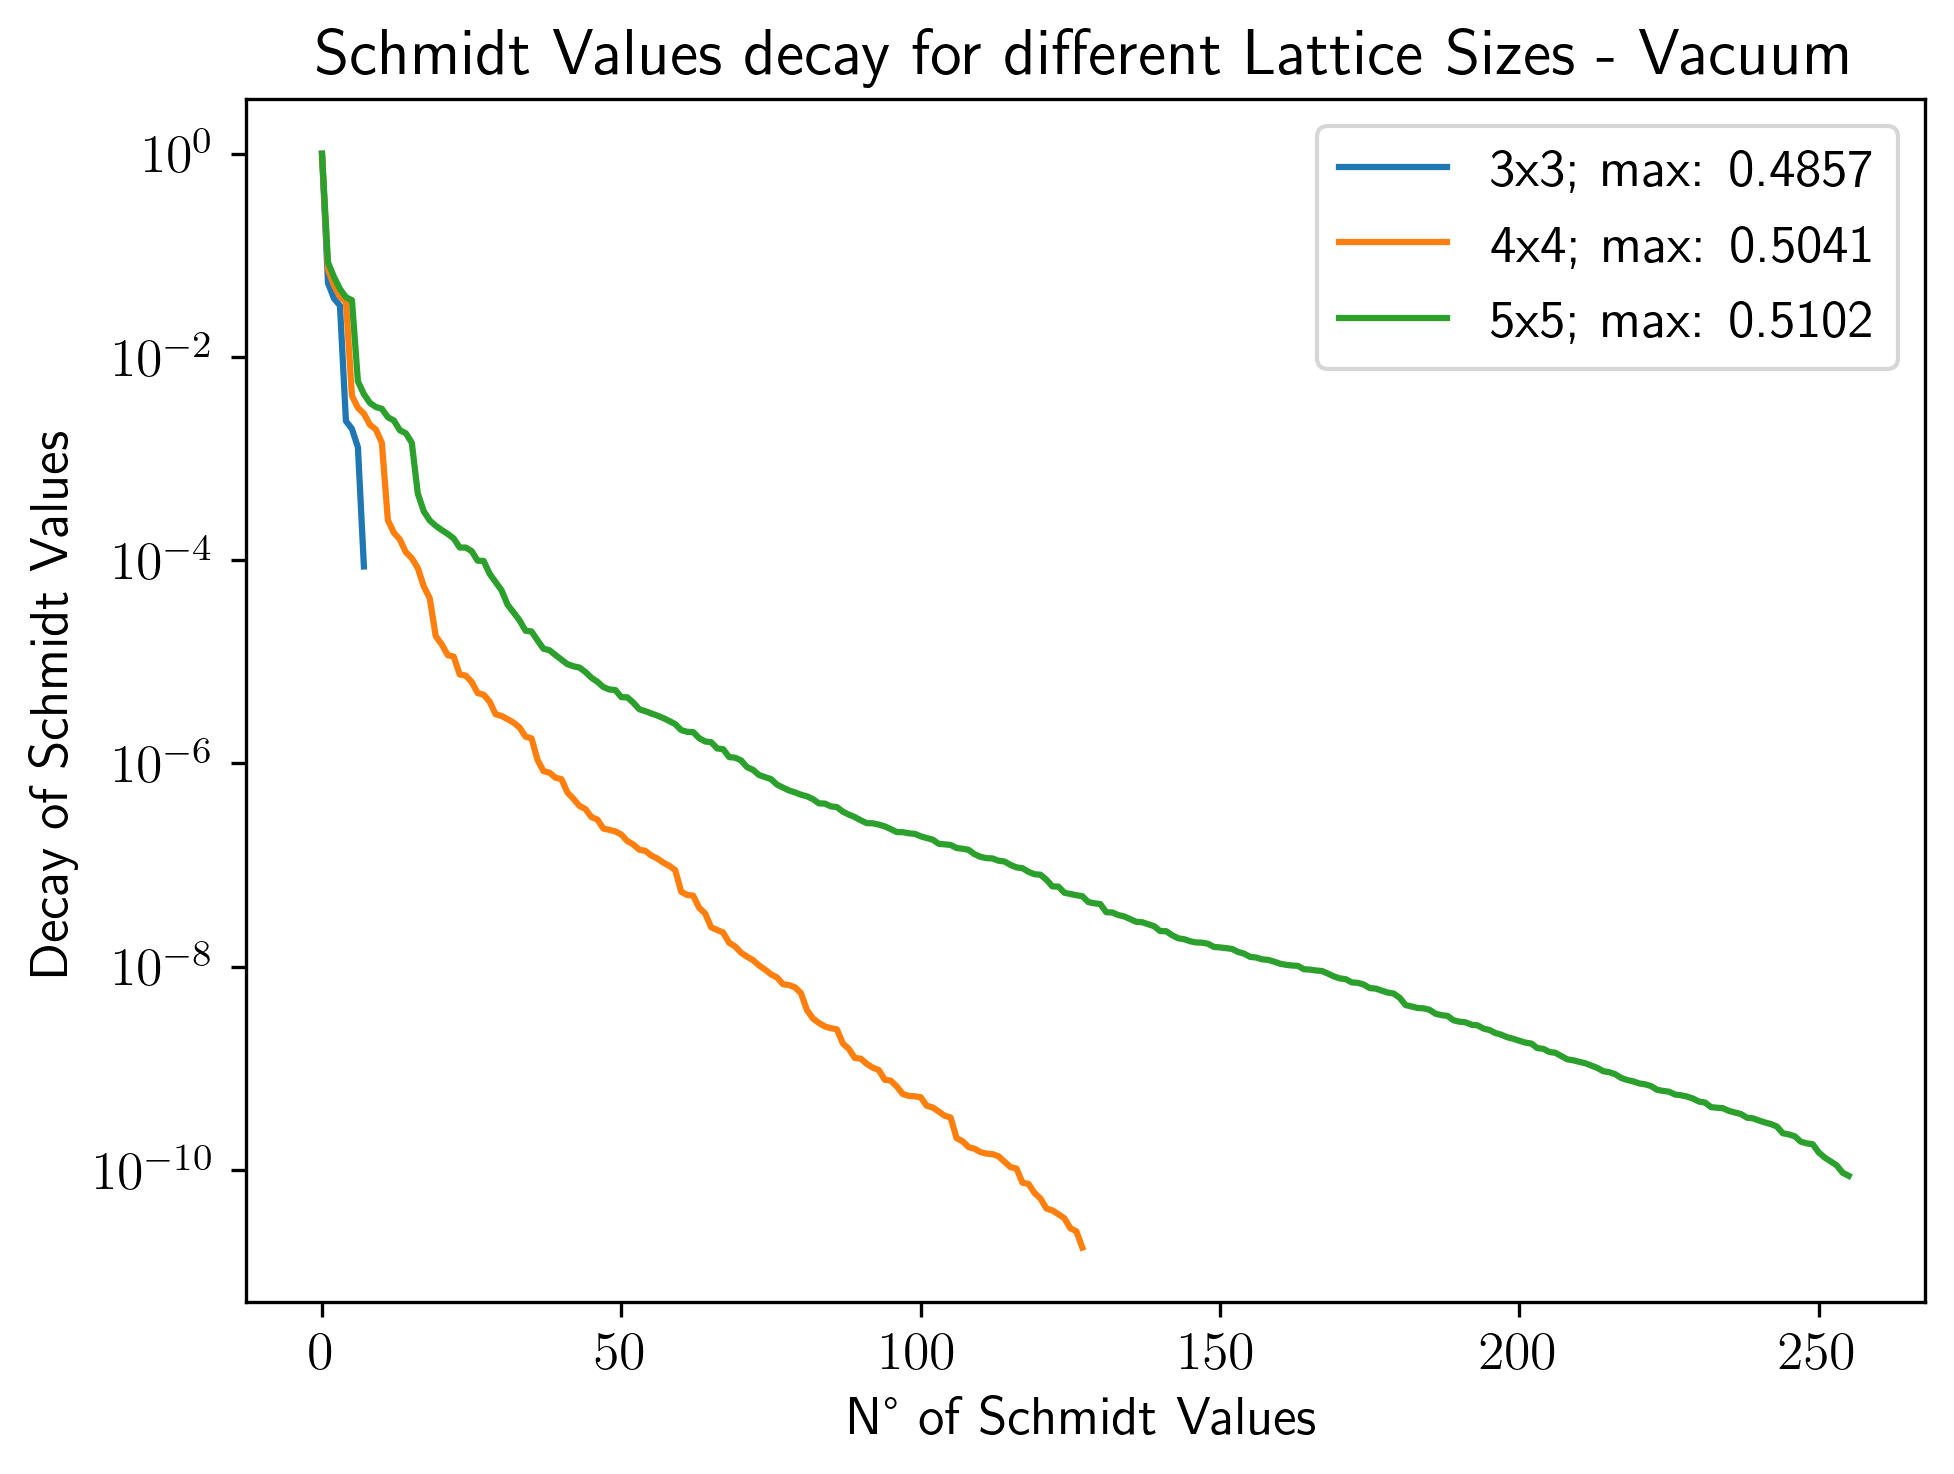

In [59]:
plt.title("Schmidt Values decay for different Lattice Sizes - Vacuum")
for schmidt_vals, L, i in zip(schmidt_vals_L, Ls, idx_max):
    plt.plot(schmidt_vals, label=f"{L-1}x{L-1}; max: {round(interval[i],4)}")
plt.yscale('log')
plt.xlabel("N° of Schmidt Values")
plt.ylabel("Decay of Schmidt Values")
plt.legend()
plt.savefig(f"{parent_path}/figures/entropy/schmidt_values_decay_at_max_entropy_Z2_dual_L_{Ls}_{sector}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}.png")
plt.show()